In [1]:
import os
#from dotenv import load_dotenv
from intake import open_catalog
import intake

import pandas as pd
import numpy as np
import geopandas as gpd

import datetime
from pystac_client import Client as psc
import stackstac
import numpy

#import dask.distributed


from pyproj import CRS
from pyproj import Transformer


C:\Users\Administrateur\AppData\Local\Temp\ipykernel_28372\2666484831.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import rioxarray

In [3]:
import rasterio
import xarray

In [4]:
from shapely.geometry import mapping

In [5]:
# Variables à changer pour récupérer les données sources de la chaîne des feux dans le système de l'oeil
# Utiliser intake et dotenv 
# Intake pour ouvrir le catalogue à partir de la db postgres de l'OEIL
# dotenv pour gérer les credentials et les chemins d'accès

PATH_GEOM = r"E:\FILES\OEIL\datas\sentinel_surfaces_detectees_sept_oct_2023.gpkg"

URL = "https://earth-search.aws.element84.com/v1"
URL_2 = "https://catalogue.dataspace.copernicus.eu/stac"
URL_3 = "https://services.sentinel-hub.com/api/v1/catalog/1.0.0/"
URL_4 = "https://earthengine.openeo.org/v1.0/"

collection = "SENTINEL-2"
collect_amazon ='sentinel-2-l2a'
collect_EE = 'COPERNICUS/S2_SR_HARMONIZED'

crs_rgnc = CRS.from_epsg(3163)
crs_4326 = CRS.from_epsg(4326)
transformer = Transformer.from_crs(crs_rgnc, crs_4326)

# On lit le fichier des surfaces brûlées dans un geodataframe
ba_test = gpd.read_file(PATH_GEOM)

# On créer une nouvelle colonne pour avoir un datetime de la date
ba_test['date_']= pd.to_datetime(ba_test['date'], format='%Y-%m-%d').dt.date

# On passe de multipolygon à polygon.
ba_test = ba_test.explode()
ba_test.head(2)

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_28372\1465758472.py:28: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  ba_test = ba_test.explode()


,,PLOTID,surface_id,date,nom,surface,her,commune,index,layer,path,date_,geometry
0,0,653,360203,2023-09-17,L2A_T58KGB,1.298902,A,LIFOU,NaN,surfaces_brulees_2023_sept_oct_HER_A_inf10,N:/Informatique/SIG/Etudes/2023/2309_QC_feux/P...,2023-09-17,"POLYGON ((546210.500 340354.400, 546220.500 34..."
1,0,828,360204,2023-09-20,L2A_T58KFC,1.110337,A,OUVEA,NaN,surfaces_brulees_2023_sept_oct_HER_A_inf10,N:/Informatique/SIG/Etudes/2023/2309_QC_feux/P...,2023-09-20,"POLYGON ((462460.300 417339.900, 462500.300 41..."


In [6]:
# On établit la liste des communes de notre geodataframe
liste_commune = list(set(ba_test["commune"]))

# On récupère les surfaces_id qui ont été photo interprétés, fournis par Oriane
surfaces_id = {
    "burned" : [358032, 358018, 358010, 359919, 359594, 359614, 358008, 359524, 359592, 359944],
    "unburned"  : [357997, 358001, 358002, 358017, 358012, 359543, 359788, 359498, 359545, 360203],
    "doubt": [358026, 358033,359595, 359964, 362134, 362171, 362192, 362851, 360718, 359666]
}

# On prend un intervalle de temps avec 120 jours avant la première date de détection de surface brûlée du geopackage des surfaces brûlées
datemin = (min(ba_test['date_']) - datetime.timedelta(days=120)).strftime('%Y-%m-%d') 
datemax = max(ba_test['date_']).strftime('%Y-%m-%d')

# On fait un test sur la surface brulée 358032
ba_test_filter = ba_test[ba_test["surface_id"]==359595]
# On créer une séries des dates de détection des surfaces brûlées pour filtrer les images sentinel2
dates_burnedarea = ba_test_filter['date_'].values
bbox = ba_test_filter["geometry"].to_crs(4326).total_bounds

# On prend un intervalle de temps avec 120 jours avant la première date de détection de surface brûlée du geopackage des surfaces brûlées
datemin = (min(ba_test_filter['date_']) - datetime.timedelta(days=120)).strftime('%Y-%m-%d') 
datemax = (max(ba_test_filter['date_'])+ datetime.timedelta(days=20)).strftime('%Y-%m-%d')

dates = f'{datemin}/{datemax}'
print(f'Emprise spatiale globale des formes identifiées {bbox}')

print(f'Interval temporel {dates}')


Emprise spatiale globale des formes identifiées [166.02926843 -21.54889321 166.0322614  -21.54654107]
Interval temporel 2023-05-13/2023-09-30


In [7]:
client = psc.open(URL)
cc=40
search = client.search(
    collections=[collect_amazon],
    bbox=bbox,
    datetime=dates
    )

print(f"{search.matched()} scenes Sentinel-2 L2A trouvées dans l'intervalle temporel")


52 scenes Sentinel-2 L2A trouvées dans l'intervalle temporel


In [8]:
items = search.item_collection()

In [9]:
ba_test_filter

,,PLOTID,surface_id,date,nom,surface,her,commune,index,layer,path,date_,geometry
1507,0,105,359595,2023-09-10,L2A_T58KFB,3.190328,E,CANALA,NaN,surfaces_brulees_2023_sept_oct_HER_E_inf10,N:/Informatique/SIG/Etudes/2023/2309_QC_feux/P...,2023-09-10,"POLYGON ((403280.900 294847.000, 403281.000 29..."


In [10]:
sentinel_stack = stackstac.stack(
                          items,
                          bounds_latlon=[bbox[0], bbox[1],  bbox[2],  bbox[3]],

                          gdal_env=stackstac.DEFAULT_GDAL_ENV.updated(
                               {'GDAL_HTTP_MAX_RETRY': 3,
                                'GDAL_HTTP_RETRY_DELAY': 5,
                               }),
                          epsg=4326
                          ).rename({'x': 'lon', 'y': 'lat'})

e:\APP_GLOBAL\PYTHON\Lib\site-packages\stackstac\prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


In [11]:
data_indices = sentinel_stack.sel(band=["blue","rededge2", "rededge3", "green","red", "nir","nir08","swir22", "scl"]).to_dataset(dim='band')
#rgb = sentinel_stack.sel(band=["red", "green", "blue"]).compute()


In [12]:
data_times = pd.to_datetime(sentinel_stack['time']).date
images_to_keep = []

for i, time in enumerate(data_times):
  if time in dates_burnedarea:
    images_to_keep.append(i)
    print(f"on conserve automatiquement l'image {i}")
    continue
  
  scl_data = sentinel_stack.isel(time = i).sel(band = "scl") 
  mask = (scl_data>=4) & (scl_data<=7)
  filtered_data = scl_data.where(mask)
  percentage = (filtered_data.count() / scl_data.count()) *100
  
  if percentage > 90:
    print(f"on prend l'image sufisamment peu couverte {i}")
    images_to_keep.append(i)

data_to_keep = sentinel_stack.isel(time=images_to_keep)

print(f"Nombre d'images après filtrage :{len(images_to_keep)}")

on prend l'image sufisamment peu couverte 0
on prend l'image sufisamment peu couverte 3
on prend l'image sufisamment peu couverte 4
on prend l'image sufisamment peu couverte 5
on prend l'image sufisamment peu couverte 6
on prend l'image sufisamment peu couverte 7
on prend l'image sufisamment peu couverte 8
on prend l'image sufisamment peu couverte 9
on prend l'image sufisamment peu couverte 10
on prend l'image sufisamment peu couverte 13
on prend l'image sufisamment peu couverte 14
on prend l'image sufisamment peu couverte 17
on prend l'image sufisamment peu couverte 18
on prend l'image sufisamment peu couverte 19
on prend l'image sufisamment peu couverte 20
on prend l'image sufisamment peu couverte 25
on prend l'image sufisamment peu couverte 26
on prend l'image sufisamment peu couverte 27
on prend l'image sufisamment peu couverte 28
on prend l'image sufisamment peu couverte 29
on prend l'image sufisamment peu couverte 30
on prend l'image sufisamment peu couverte 31
on prend l'image s

In [13]:
data_indices = data_to_keep.sel(band=["blue","rededge2", "rededge3", "green","red", "nir","nir08","swir22", "scl"]).to_dataset(dim='band')

"""
Correction des valeurs de bandes, on avait des valeurs négatives de reflectance par endroit
"""
"""
data_indices["red+"]=data_indices["red"].where(lambda x : x>0, lambda x : -x)
data_indices["nir+"]=data_indices["nir"].where(lambda x : x>0, lambda x : -x)
data_indices["swir22+"]=data_indices["swir22"].where(lambda x : x>0, lambda x : -x)
data_indices["green+"]=data_indices["green"].where(lambda x : x>0, lambda x : -x)
data_indices["blue+"]=data_indices["blue"].where(lambda x : x>0, lambda x : -x)
data_indices["nir08+"]=data_indices["nir08"].where(lambda x : x>0, lambda x : -x)
data_indices["rededge2+"]=data_indices["rededge2"].where(lambda x : x>0, lambda x : -x)
data_indices["rededge3+"]=data_indices["rededge3"].where(lambda x : x>0, lambda x : -x)
"""
data_indices["red"] = data_indices["red"]+0.1
data_indices["nir"] = data_indices["nir"]+0.1
data_indices["swir22"] = data_indices["swir22"]+0.1
data_indices["green"] = data_indices["green"]+0.1
data_indices["blue"] = data_indices["blue"]+0.1
data_indices["nir08"] = data_indices["nir08"]+0.1
data_indices["rededge2"] = data_indices["rededge2"]+0.1
data_indices["rededge3"] = data_indices["rededge3"]+0.1

In [14]:
data_indices['ndvi'] = ((data_indices['nir'].astype(float) - data_indices['red'].astype(float))/(data_indices['nir'].astype(float)+ data_indices['red'].astype(float)))

data_indices['nbr'] = ((data_indices['nir'] - data_indices['swir22'])/(data_indices['nir'] + data_indices['swir22']))

data_indices['nbr+'] = ((data_indices['swir22'] - data_indices['nir08'] - data_indices['green'] - data_indices['blue'])/(data_indices['swir22'] + data_indices['nir08'] + data_indices['green'] + data_indices['blue']))

data_indices['bais2'] = (1-(numpy.sqrt((data_indices['rededge2'] * data_indices['rededge3'] * data_indices['nir08'])/data_indices['red']))*((data_indices['swir22'] - data_indices['nir08'] )/ numpy.sqrt((data_indices['swir22'] + data_indices['nir08'] ))+1))

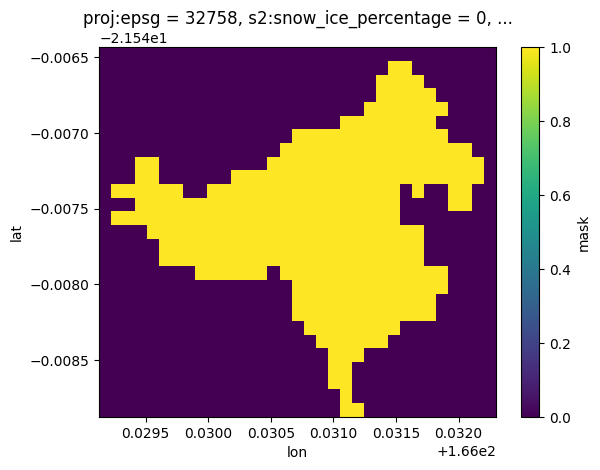

In [15]:
ShapeMask = rasterio.features.geometry_mask(ba_test_filter['geometry'].to_crs(4326).apply(mapping),
                                            out_shape =(len(data_indices.lat), len(data_indices.lon)),
                                            transform = data_indices.transform,
                                            invert = True)
ShapeMask = xarray.DataArray(ShapeMask, dims = ("lat","lon"))
data_indices['mask'] = ShapeMask
data_indices['mask'].plot()

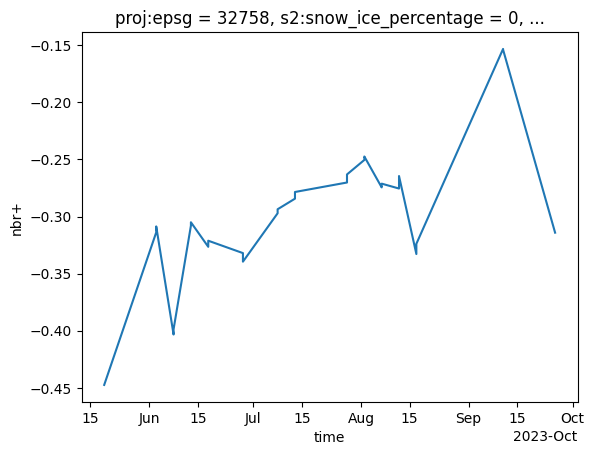

In [16]:
data_indices["nbr+"].where(data_indices["mask"]).mean(dim=["lat", "lon"]).plot()

In [17]:
ba_test_filter["date"]

1507  0    2023-09-10
Name: date, dtype: object

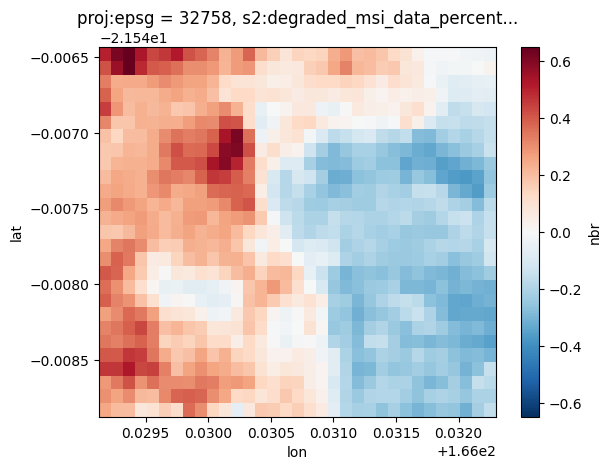

In [73]:
(data_indices['nbr'].isel(time=16)-data_indices['nbr'].isel(time=27)).plot()


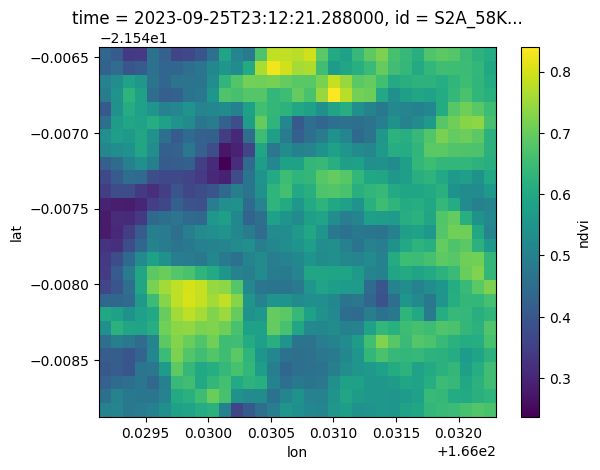

In [71]:
data_indices["ndvi"].isel(time=27).plot()

2023-09-10


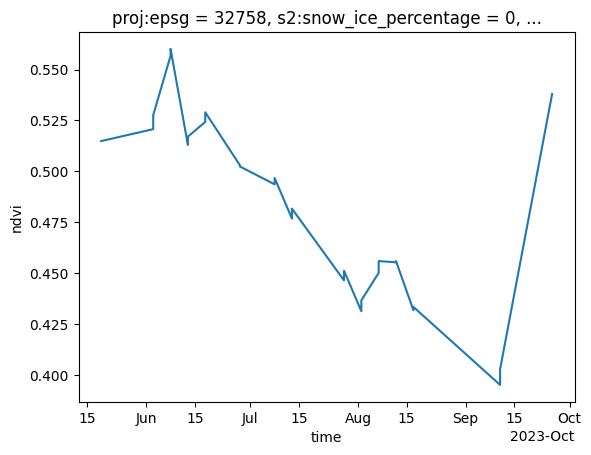

In [25]:
data_1D = data_indices.where(data_indices['mask']).data_vars['ndvi'].mean(dim = ["lat", "lon"])
print(ba_test_filter["date_"].iloc[0])
data_1D.plot()

In [ ]:
dataset = data_indices.to_dataarray(dim="bands")

In [ ]:
data_rgb = dataset.sel(bands=["red", "green", "blue"])

In [68]:
ba_test_filter

,,PLOTID,surface_id,date,nom,surface,her,commune,index,layer,path,date_,geometry
1507,0,105,359595,2023-09-10,L2A_T58KFB,3.190328,E,CANALA,NaN,surfaces_brulees_2023_sept_oct_HER_E_inf10,N:/Informatique/SIG/Etudes/2023/2309_QC_feux/P...,2023-09-10,"POLYGON ((403280.900 294847.000, 403281.000 29..."


In [28]:
dataset_save = data_indices.drop([c for c in data_indices.coords if not (c in ['time', 'lat', 'lon'])])

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_28372\2097862134.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  dataset_save = data_indices.drop([c for c in data_indices.coords if not (c in ['time', 'lat', 'lon'])])


In [31]:
dataset_save = dataset_save.drop_vars([v for v in dataset_save.data_vars if not (v in ['ndvi', 'nbr', 'nbr+', 'bais2', 'mask'])])

In [67]:
dataset_save.to_netcdf(f"{str(ba_test_filter["surface_id"].iloc[0])}_{str(ba_test_filter["nom"].iloc[0])}_{str(ba_test_filter["date"].iloc[0])}.nc")

In [51]:
dataset_save.attrs['spec'] = str(dataset_save.attrs['spec'])

In [69]:
dataset_save

<xarray.Dataset>
Dimensions:  (time: 28, lon: 33, lat: 27)
Coordinates:
  * time     (time) datetime64[ns] 2023-05-18T23:12:17.678000 ... 2023-09-25T...
  * lon      (lon) float64 166.0 166.0 166.0 166.0 ... 166.0 166.0 166.0 166.0
  * lat      (lat) float64 -21.55 -21.55 -21.55 -21.55 ... -21.55 -21.55 -21.55
Data variables:
    ndvi     (time, lat, lon) float64 dask.array<chunksize=(1, 27, 33), meta=np.ndarray>
    nbr      (time, lat, lon) float64 dask.array<chunksize=(1, 27, 33), meta=np.ndarray>
    nbr+     (time, lat, lon) float64 dask.array<chunksize=(1, 27, 33), meta=np.ndarray>
    bais2    (time, lat, lon) float64 dask.array<chunksize=(1, 27, 33), meta=np.ndarray>
    mask     (lat, lon) bool False False False False ... False False False False
Attributes:
    spec:           RasterSpec(epsg=4326, bounds=(166.0291759065001, -21.5489...
    crs:            epsg:4326
    transform:      | 0.00, 0.00, 166.03|\n| 0.00,-0.00,-21.55|\n| 0.00, 0.00...
    resolution_xy:  (9.609220910533622e-05, 9.035868280449222e-05)

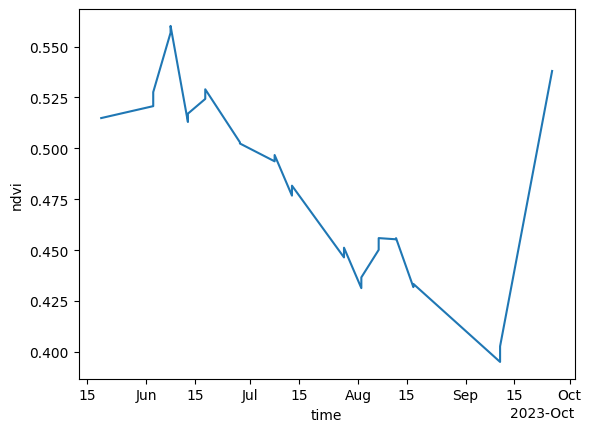

In [65]:
dataset_save['ndvi'].where(dataset_save['mask']).mean(dim=["lat", 'lon']).plot()

In [66]:
! pip install netCDF4

  Using cached netCDF4-1.6.5-cp312-cp312-win_amd64.whl.metadata (1.8 kB)
   ---------------------------------------- 0.0/6.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/6.6 MB 660.6 kB/s eta 0:00:10
    --------------------------------------- 0.1/6.6 MB 1.6 MB/s eta 0:00:05
   - -------------------------------------- 0.3/6.6 MB 2.4 MB/s eta 0:00:03
   -- ------------------------------------- 0.4/6.6 MB 2.6 MB/s eta 0:00:03
   --- ------------------------------------ 0.6/6.6 MB 2.7 MB/s eta 0:00:03
   ---- ----------------------------------- 0.7/6.6 MB 2.8 MB/s eta 0:00:03
   ----- ---------------------------------- 0.9/6.6 MB 3.1 MB/s eta 0:00:02
   ----- ---------------------------------- 1.0/6.6 MB 2.9 MB/s eta 0:00:02
   ------ --------------------------------- 1.0/6.6 MB 3.0 MB/s eta 0:00:02
   ------ --------------------------------- 1.1/6.6 MB 2.7 MB/s eta 0:00:03
   ------- -------------------------------- 1.3/6.6 MB 2.8 MB/s eta 0:00:02
   --------- -------

DEPRECATION: Loading egg at e:\app_global\python\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
